<a name='title'></a>
# Recomendación musical en KKBox


## Índice

- [Descripción](#1)
    - [Imports](#1.1)

- [Análisis de los datos](#2)

- [Ingeniería de variables](#3)

- [Entrenamiento del modelo](#4)

- [Resultados y conclusión](#5)

- [Anexo](#6)
    - [Estudios preliminares](#6.1)
    - [Elementos no incluídos](#6.2)
    - [Código](#6.3)

<a name='1'></a>
## Descripción 

Nuestro dataset consiste en varias tablas con información relativa a canciones, usuarios y escuchas realizadas por estos usuarios en la aplicación KKBox, plataforma musical líder en la mayoría de países asiáticos. El objetivo del trabajo será idear un sistema de recomendación de canciones.

KKBOX proporciona un conjunto de datos de entrenamiento que consiste en información del primer evento de escucha observable para cada par único de usuario y canción dentro de un tiempo específico. El objetivo será predecir las posibilidades de que un usuario escuche una canción repetidamente después de que se active el primer evento de escucha. Si hay eventos de escucha activados dentro de un mes después del primer evento de escucha observable del usuario, su objetivo se marca 1 y 0 de lo contrario en el conjunto de entrenamiento. La misma regla se aplica al conjunto de test.

En resumidas cuentas la meta del trabajo será el estudio del dataset para elaborar un modelo que prediga si un usuario dará más escuchas a una canción que ha sido escuchada una vez por parte del mismo.

La idea de este trabajo tiene su origen en un reto por parte de la conferencia *International Conference on Web Search and Data Mining* (WSDM), que proporciona este dataset donado por la propia aplicación KKBox, a los usuarios de Kaggle ML para elaborar un mejor modelo de recomendación musical que el suyo en 2018.

Pedro Chans Fanego.


<a name='1.1'></a>
### Imports

In [1]:
!pip install -r requirements.txt

In [2]:
import zipfile
import py7zr
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import gc
import seaborn as sns 
import missingno as msno
import warnings
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve


<a name='2'></a>
## Análisis de los datos

Comenzaremos el trabajo con un breve análisis. Leeremos los datos, mostraremos el tabular, describiremos las columnas e imprimiremos una fila de cada tabla para tener una idea inicial.

### Instrucciones para el usuario:
Para poder descargar los datos desde Kaggle, necesitas una API key de Kaggle.
1. Ve a tu cuenta de Kaggle (https://www.kaggle.com/account)
2. En la sección API, haz clic en "Create New API Token". Esto descargará el archivo kaggle.json.
3. Coloca el archivo kaggle.json en la carpeta ~/.kaggle/ (en sistemas UNIX como Linux/Mac) o en C:\Users\TU_USUARIO\.kaggle\ (en Windows).
4. Asegúrate de que la carpeta tenga los permisos adecuados (chmod 600 en UNIX).

Alternativa manual: navega a la URL https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data, descarga y descomprime los archivos en una carpeta /kaggle_data en la misma ubicación que el notebook.

In [3]:
!kaggle competitions download -c kkbox-music-recommendation-challenge


  0%|          | 0.00/345M [00:00<?, ?B/s]
  0%|          | 1.00M/345M [00:00<03:38, 1.65MB/s]
  1%|          | 2.00M/345M [00:00<02:10, 2.75MB/s]
  1%|          | 3.00M/345M [00:00<01:34, 3.79MB/s]
  1%|          | 4.00M/345M [00:01<01:18, 4.56MB/s]
  1%|▏         | 5.00M/345M [00:01<01:15, 4.72MB/s]
  2%|▏         | 6.00M/345M [00:01<01:03, 5.56MB/s]
  2%|▏         | 7.00M/345M [00:01<00:59, 5.91MB/s]
  2%|▏         | 8.00M/345M [00:01<00:56, 6.25MB/s]
  3%|▎         | 9.00M/345M [00:01<00:55, 6.30MB/s]
  3%|▎         | 10.0M/345M [00:02<00:54, 6.42MB/s]
  3%|▎         | 11.0M/345M [00:02<00:54, 6.44MB/s]
  3%|▎         | 12.0M/345M [00:02<00:53, 6.49MB/s]
  4%|▍         | 13.0M/345M [00:02<00:53, 6.52MB/s]
  4%|▍         | 14.0M/345M [00:02<00:51, 6.71MB/s]
  4%|▍         | 15.0M/345M [00:02<00:52, 6.62MB/s]
  5%|▍         | 16.0M/345M [00:03<00:49, 6.93MB/s]
  5%|▍         | 17.0M/345M [00:03<00:47, 7.20MB/s]
  5%|▌         | 18.0M/345M [00:03<00:47, 7.26MB/s]
  6%|▌         | 19.

In [4]:
# Descomprimir el archivo descargado
with zipfile.ZipFile("kkbox-music-recommendation-challenge.zip", 'r') as zip_ref:
    zip_ref.extractall("kkbox_data")  # Carpeta donde se extraerán los archivos

# Ruta de la carpeta que contiene los archivos .7z
folder_path = './kkbox_data'

# Verificar si la carpeta existe
if os.path.exists(folder_path):
    # Listar todos los archivos en la carpeta
    for file_name in os.listdir(folder_path):
        # Verificar si el archivo tiene extensión .7z
        if file_name.endswith('.7z'):
            file_path = os.path.join(folder_path, file_name)
            print(f"Descomprimiendo {file_path}...")
            
            # Descomprimir el archivo .7z
            with py7zr.SevenZipFile(file_path, mode='r') as z:
                z.extractall(path=folder_path)
                
            print(f"Archivo {file_name} descomprimido.")
else:
    print(f"La carpeta {folder_path} no existe.")

Descomprimiendo ./kkbox_data\members.csv.7z...
Archivo members.csv.7z descomprimido.
Descomprimiendo ./kkbox_data\sample_submission.csv.7z...
Archivo sample_submission.csv.7z descomprimido.
Descomprimiendo ./kkbox_data\songs.csv.7z...
Archivo songs.csv.7z descomprimido.
Descomprimiendo ./kkbox_data\song_extra_info.csv.7z...
Archivo song_extra_info.csv.7z descomprimido.
Descomprimiendo ./kkbox_data\test.csv.7z...
Archivo test.csv.7z descomprimido.
Descomprimiendo ./kkbox_data\train.csv.7z...
Archivo train.csv.7z descomprimido.


In [5]:
train = pd.read_csv('./kkbox_data/train.csv')
test = pd.read_csv('./kkbox_data/test.csv')
songs = pd.read_csv('./kkbox_data/songs.csv')
members = pd.read_csv('./kkbox_data/members.csv')

![](tabular_tfm.png)

Esta es una representación de las relaciones existentes entre nuestras tablas, la relación entre las canciones y los eventos de escucha (train) es 1:N, del mismo modo que entre miembros y eventos de escucha, 1:N. No hemos incluído en esta representación la tabla *test.csv*, que como sabemos, tiene los mismos campos y relaciones que train, a excepción del campo *target*.

Vamos con una descripción de algunos campos:

**train.csv**
- *msno*: ID de usuario
- *source_system_tab*: el nombre de la pestaña donde se activó el evento de escucha. Las pestañas del sistema se utilizan para categorizar las funciones de las aplicaciones móviles de KKBOX. Por ejemplo, la pestaña mi biblioteca contiene funciones para manipular el almacenamiento local, y la pestaña de búsqueda contiene funciones relacionadas con la búsqueda.
- *source_screen_name*: nombre de la pantalla que ve un usuario.
- *source_type*: un punto de entrada en el que un usuario reproduce música por primera vez en aplicaciones móviles. Un punto de entrada podría ser un álbum, una lista de reproducción en línea, una canción, etc.
- *target*: esta es la variable objetivo. *target*=1 significa que hay eventos de escucha recurrentes activados dentro de un mes después del primer evento de escucha observable del usuario, *target*=0 de lo contrario.

**songs.csv**
- *song_length*: en milisegundos
- *genre_ids*: género musical, algunas canciones tienen múltiples géneros separados por |

**members.csv**
- *bd*: edad
- *registered_via*: método de registro
- *registration_init_time*: formato %Y%m%d
- *expiration_date*: format %Y%m%d

In [23]:
train.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1


In [24]:
songs.head(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0


In [25]:
members.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920


Visualización de las variables de **train.csv**:

<Figure size 432x288 with 0 Axes>

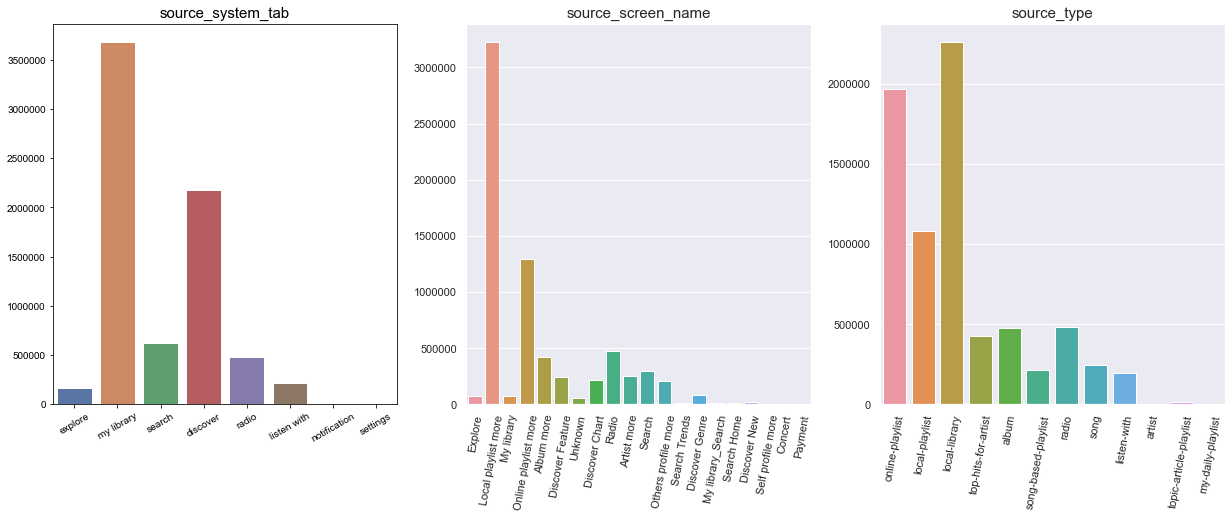

In [26]:
plt.clf()
plt.figure(figsize=(21, 7))
plt.subplot(131)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_system_tab',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_system_tab',fontsize=15)
plt.xticks(rotation='30')

plt.subplot(132)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_screen_name',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_screen_name',fontsize=15)
plt.xticks(rotation='80')

plt.subplot(133)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_type',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_type',fontsize=15)
plt.xticks(rotation='80')

plt.show()


Para un análisis más detallado podemos acudir al anexo [estudios preliminares](#6.1), dónde conoceremos a fondo nuestro conjunto de datos. Este anexo no tiene cabida en la extensión del trabajo, pero podemos hacer referencia a sus conclusiones.

<a name='3'></a>
## Ingeniería de variables

Comenzaremos simplificando nuestro tabular en una sola tabla, mediante un par de inner joins entre las tablas iniciales. De este modo, y gracias a que las relaciones son 1:N, tendremos en una sola tabla información sobre el evento de escucha, la canción y el artista.

In [27]:
train_members = pd.merge(train, members, on='msno', how='inner')
df_train = pd.merge(train_members, songs, on='song_id', how='left')
df_train.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0


In [28]:
test_members = pd.merge(test, members, on='msno', how='inner')
df_test = pd.merge(test_members, songs, on='song_id', how='left')
df_test.head(1)

,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,NaN,7,20160219,20170918,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0


In [29]:
del train_members
del test_members

Vamos a comenzar nuestra ingeniería de variables por un estudio de los NA. Como hemos visto en los estudios preliminares, intuímos que hay NA's que vienen como 0's en Edad, como 1's en City, y como -1's en Language. Vamos a unificarlos con el valor -5:

In [30]:
print(sum(df_train.city == 1),sum(df_train.language == -1),sum(df_train.bd == 0),sum(df_test.city == 1),sum(df_test.language == -1),sum(df_test.bd == 0))
df_train.loc[df_train['city']==1,'city'] = -5
df_train.loc[df_train['language']==-1,'language'] = -5
df_train.loc[df_train['bd']==0,'bd'] = -5
df_test.loc[df_test['city']==1,'city'] = -5
df_test.loc[df_test['language']==-1,'language'] = -5
df_test.loc[df_test['bd']==0,'bd'] = -5
print(sum(df_train.city == 1),sum(df_train.language == -1),sum(df_train.bd == 0),sum(df_test.city == 1),sum(df_test.language == -1),sum(df_test.bd == 0))


2621293 308752 2940499 935979 116856 1043221
0 0 0 0 0 0


Vamos a sacar las variables temporales derivadas de la fecha y eliminamos la original del dataset tanto para la fecha de registro como la de expiración de la suscripción. Definimos también la variable de duración de la membresía del usuario en días y en meses.

Tras unas pruebas con el modelo, concluímos que la única variable temporal útil son los años, hemos decidido eliminar los meses y días.

In [31]:
# registration_init_time
df_train.registration_init_time = pd.to_datetime(df_train.registration_init_time, format='%Y%m%d', errors='ignore')
df_train['registration_year'] = df_train['registration_init_time'].dt.year
#df_train['registration_month'] = df_train['registration_init_time'].dt.month
#df_train['registration_day'] = df_train['registration_init_time'].dt.day

df_test.registration_init_time = pd.to_datetime(df_test.registration_init_time, format='%Y%m%d', errors='ignore')
df_test['registration_year'] = df_test['registration_init_time'].dt.year
#df_test['registration_month'] = df_test['registration_init_time'].dt.month
#df_test['registration_day'] = df_test['registration_init_time'].dt.day

# expiration_date
df_train.expiration_date = pd.to_datetime(df_train.expiration_date,  format='%Y%m%d', errors='ignore')
df_train['expiration_year'] = df_train['expiration_date'].dt.year
#df_train['expiration_month'] = df_train['expiration_date'].dt.month
#df_train['expiration_day'] = df_train['expiration_date'].dt.day

df_test.expiration_date = pd.to_datetime(df_test.expiration_date,  format='%Y%m%d', errors='ignore')
df_test['expiration_year'] = df_test['expiration_date'].dt.year
#df_test['expiration_month'] = df_test['expiration_date'].dt.month
#df_test['expiration_day'] = df_test['expiration_date'].dt.day

# duration
df_train['membership_days'] = (df_train['expiration_date'] - df_train['registration_init_time']).dt.days.astype(int)
df_test['membership_days'] = (df_test['expiration_date'] - df_test['registration_init_time']).dt.days.astype(int)
df_train['membership_months'] = df_train['membership_days']//30.42
df_test['membership_months'] = df_test['membership_days']//30.42

# drops
df_train = df_train.drop('registration_init_time', axis=1)
df_test = df_test.drop('registration_init_time', axis=1)
df_train = df_train.drop('expiration_date', axis=1)
df_test = df_test.drop('expiration_date', axis=1)

Otra variable que podemos definir es el año de publicación de la canción. Esta información podemos obtenerla tras un análisis de la información extra de las canciones que podemos encontrar en un documento adicional entre las entradas, y es que incluye el código ISRC de cada canción. Este código incluye entre otras cosas esta información, como se muestra en la imagen:

<img src="./codigo_isrc.png" width="400"> 

Como el año de publicación del dataset es 2017 podemos asumir que si esos dos dígitos son mayores que 17 estamos hablando del siglo XX y si son menores, del siglo XXI. 

In [32]:
song_extra_info = pd.read_csv('./kkbox_data/song_extra_info.csv')

def isrc_to_year(isrc):
    if not pd.isnull(isrc) and type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7]) 
        else:
            return 2000 + int(isrc[5:7])
    else:
        return -5

song_extra_info['song_year'] = song_extra_info['isrc'].apply(isrc_to_year).apply(int)
song_extra_info.drop(['isrc', 'name'], axis = 1, inplace = True)

df_train = df_train.merge(song_extra_info, on = 'song_id', how = 'left')
df_test = df_test.merge(song_extra_info, on = 'song_id', how = 'left')

Consideramos que nos podemos quedar con el primer género asociado a cada canción, no entraremos a trabajar con géneros múltiples cuando esta es la única categórica que puede tomar más de un valor en un conjunto de más de 7 millones de filas. Lo que sí nos guardaremos será una variable adicional con el número de géneros a los que pertenece cada canción.

In [33]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
df_train['genre_ids'].fillna('no_genre_id' , inplace= True)
df_train['genre_ids_count'] = df_train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
df_test['genre_ids'].fillna('no_genre_id' , inplace= True)
df_test['genre_ids_count'] = df_test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

df_train['genre_ids'] = df_train['genre_ids'].str.split('|').str[0]
df_test['genre_ids'] = df_test['genre_ids'].str.split('|').str[0]

Una vez rematada la creación de nuevas variables de utilidad para el modelo, procederemos a estudiar y reemplazar los valores nulos, y a dar formato a nuestro gran conjunto de datos para hacerlo más ligero y manejable.

<AxesSubplot:>

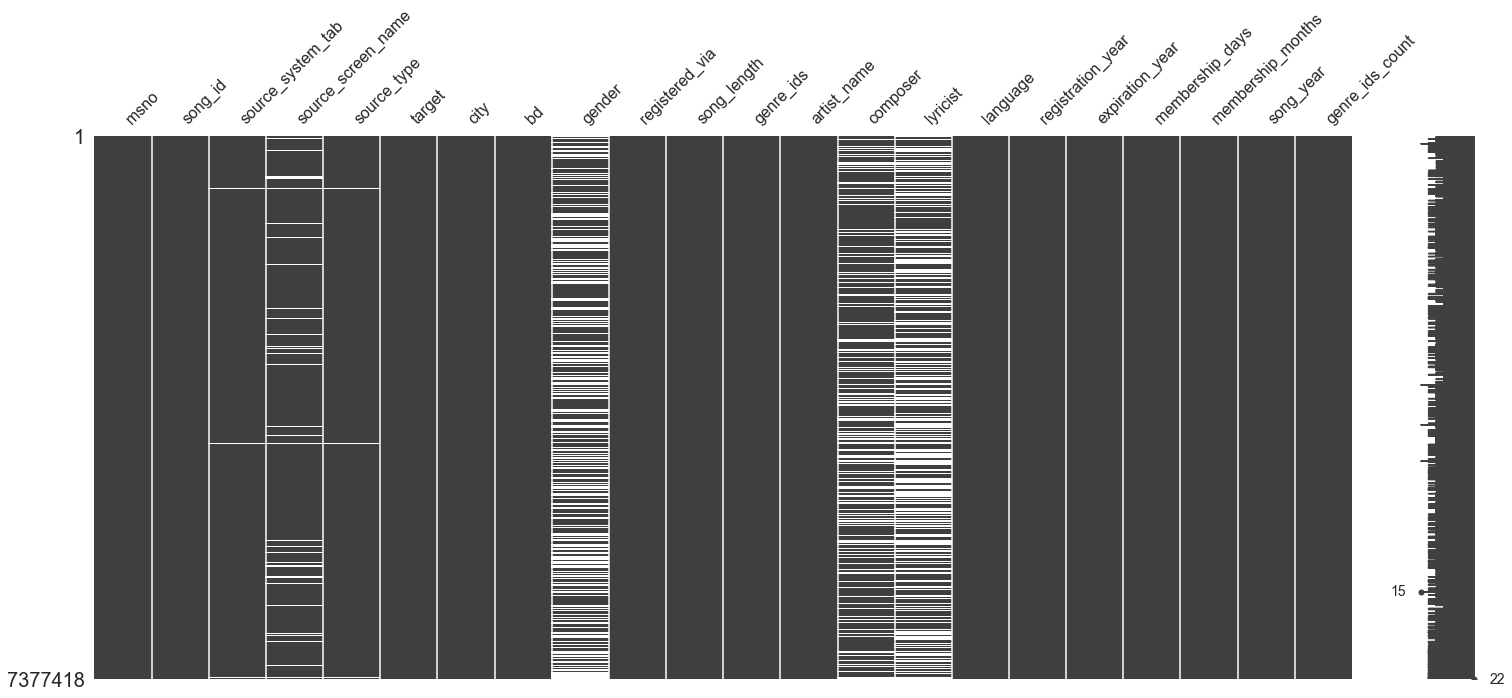

In [34]:
msno.matrix(df_train)

En primer lugar vamos a darle el valor -5 a todos los valores nulos de campos numéricos, del mismo modo que hemos hecho hasta ahora. También le daremos el valor 'unknown' a los nulos en variables categóricas. 

Para las variables longitud de la canción e idioma vamos a utilizar la media y la moda para reemplazar los nulos.

También hemos decidido que para las variables compositor y liricista vamos a poner el nombre del artista si existe, ya que no es un disparate atribuir la letra y la composición al artista si estos campos vienen en blanco, muchas veces ocurrirá que el artista es el propio compositor o liricista, y lo peor que puede suceder es que el campo venga nulo por error o que le atribuyamos el ser liricista a una canción sin letra.

In [35]:
def replace_NA_non_object(df):
    object_cols = list(df.select_dtypes(include=['float64','int64']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(int(-5))

def replace_NA_object(df):
    for i in df.select_dtypes(include=['object']).columns:
        df.loc[df[i].isnull(),i] = 'unknown'

df_train['song_length'].fillna(df_train['song_length'].mean() , inplace = True)
df_train['language'].fillna(df_train['language'].mode().values[0] , inplace= True)
df_test['song_length'].fillna(df_test['song_length'].mean() , inplace = True)
df_test['language'].fillna(df_test['language'].mode().values[0] , inplace= True)

df_train.loc[df_train['composer'].isnull(),'composer'] = df_train.loc[df_train['composer'].isnull(),'artist_name']
df_train.loc[df_train['lyricist'].isnull(),'lyricist'] = df_train.loc[df_train['lyricist'].isnull(),'artist_name']
replace_NA_non_object(df_train)
replace_NA_non_object(df_test)
replace_NA_object(df_train)
replace_NA_object(df_test)
 
print(df_train.isnull().values.any(),df_test.isnull().values.any()) # comprobacion de que no quedan NA

False False


Recordemos que estamos trabajando con unos datos de una longitud muy elevada, tenemos más de 7 millones de registros en el conjunto de entrenamiento y esto puede suponer una necesidad de una capacidad grande de almacenamiento. Es por eso que en nuestra ingeniería de variables debemos incluir una sección dedicada a la optimización de recursos, en concreto de memoria.

Vamos a transformar las variables numéricas reservando únicamente el espacio necesario para cada una, vemos que solo con esto la reducción de espacio del documento es importante.

In [36]:
print("Memoria consumida por el conjunto de training/test antes de los cambios de tipo de dato de las variables numéricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

def asign_numeric_datatypes(df):
    float_cols = list(df.select_dtypes(include=['int','float']).columns) 
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

asign_numeric_datatypes(df_train)
asign_numeric_datatypes(df_test)

print("Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables numéricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

Memoria consumida por el conjunto de training/test antes de los cambios de tipo de dato de las variables numéricas :   1217.1681537628174 / 421.8336772918701 MB
Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables numéricas :   766.8862934112549 / 273.0946350097656 MB


Para terminar con este apartado, convertiremos los objetos a variables categóricas, y alguna variable más a entero. De nuevo se puede ver el gran efecto en la reducción de tamaño debido al gran volumen de nuestro conjunto de datos. Tras esto, podemos echar un vistazo general a nuestro conjunto de datos antes de pasar a la siguiente etapa.

In [37]:
print("Memoria consumida por el conjunto de training/test antes de los cambios de tipo de dato de las variables categóricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

# Se puede cambiar a funcion que pase object a category y probar#
df_train = df_train.astype({
                    'msno' : 'category',
                    'song_id' : 'category',
                    'source_system_tab' : 'category',
                    'source_screen_name' : 'category',
                    'source_type' : 'category',
                    'target' : 'int8',
                    'city' : 'category',
                    'bd' : 'int8',
                    'gender' : 'category',
                    'registered_via' : 'category',
                    'genre_ids' : 'category',
                    'artist_name' : 'category',
                    'composer' : 'category',
                    'lyricist' : 'category',
                    'language' : 'category'                    
                })

df_test = df_test.astype({
                    'msno' : 'category',
                    'song_id' : 'category',
                    'source_system_tab' : 'category',
                    'source_screen_name' : 'category',
                    'source_type' : 'category',
                    'city' : 'category',
                    'bd' : 'int8',
                    'gender' : 'category',
                    'registered_via' : 'category',
                    'genre_ids' : 'category',
                    'artist_name' : 'category',
                    'composer' : 'category',
                    'lyricist' : 'category',
                    'language' : 'category'                    
                })

print("Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables categóricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

Memoria consumida por el conjunto de training/test antes de los cambios de tipo de dato de las variables categóricas :   766.8862934112549 / 273.0946350097656 MB
Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables categóricas :   384.5170097351074 / 139.16364097595215 MB


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 22 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              int8    
 6   city                category
 7   bd                  int8    
 8   gender              category
 9   registered_via      category
 10  song_length         int32   
 11  genre_ids           category
 12  artist_name         category
 13  composer            category
 14  lyricist            category
 15  language            category
 16  registration_year   int16   
 17  expiration_year     int16   
 18  membership_days     int16   
 19  membership_months   int16   
 20  song_year           int16   
 21  genre_ids_count     int8    
dtypes: category(13), int16(5), int32(1), int8(3)
memory usage: 384.5 M

<a name='4'></a>
## Entrenamiento del modelo

Comenzamos la parte final del trabajo, el entrenamiento de nuestro modelo.

En este trabajo hemos seleccionado el algoritmo Light GBM, es un algoritmo de potenciación de gradientes basado en modelos de árboles de decisión, en el que, a diferencia de otros modelos, los árboles tienen un crecimiento vertical en lugar de horizontal. El motivo de que este algoritmo sea el que se ajusta mejor a nuestras necesidades es que es un algoritmo que tiene muy buena velocidad de procesado y funciona muy bien con volumenes de datos muy grandes, como el que incluímos en este trabajo. Además no necesita mucha memoria, gracias a las técnicas de reemplazado continuo. Otros algoritmos como XGBoost resultan inmanejables con un conjunto de datos como este debido a su largo tiempo de procesado, y no obtienen mejores resultados. Además, el algoritmo Light GBM es sensible a sobreajustes, especialmente en conjuntos pequeños de datos, pero como ya hemos señalado, este no será el caso.

Crearemos tres splits de nuestros conjuntos de entrenamiento y test, y ajustaremos los parámetros:

In [39]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

predictions = np.zeros(shape=[len(df_test)])

for train_indices ,validate_indices in kf.split(df_train) : 
    train_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[train_indices,:],label=df_train.loc[train_indices,'target'])
    val_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[validate_indices,:],label=df_train.loc[validate_indices,'target'])

    params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 2**8,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 80,
        'metric' : 'auc'
    }
    lgbm_model = lgb.train(params, train_data, 100, valid_sets=[val_data])
    predictions += lgbm_model.predict(df_test.drop(['id'],axis=1))
    del lgbm_model

predictions = predictions/3

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194162 seconds.
You can set `force_col_wise=true` to remove the overhead.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.678858
[2]	valid_0's auc: 0.687804
[3]	valid_0's auc: 0.688057
[4]	valid_0's auc: 0.687912
[5]	valid_0's auc: 0.688177
[6]	valid_0's auc: 0.688052
[7]	valid_0's auc: 0.688656
[8]	valid_0's auc: 0.690064
[9]	valid_0's auc: 0.690732
[10]	valid_0's auc: 0.690637
[11]	valid_0's auc: 0.691255
[12]	valid_0's auc: 0.691357
[13]	valid_0's auc: 0.691823
[14]	valid_0's auc: 0.691867
[15]	valid_0's auc: 0.691981
[16]	valid_0's auc: 0.69373
[17]	valid_0's auc: 0.693714
[18]	valid_0's auc: 0.693788
[19]	valid_0's auc: 0.69402
[20]	valid_0's auc: 0.694937
[21]	valid_0's auc: 0.695025
[22]	valid_0's auc: 0.695191
[23]	valid_0's auc: 0.695193
[24]	valid_0's auc: 0.695291
[25]	valid_0's auc: 0.695262
[26]	valid_0's auc: 0.695492
[27]	valid_0's auc: 0.695524
[28]	valid_0's auc: 0.695588
[29]	valid_0's auc: 0.696182
[30]	valid_0's auc: 0.696158
[31]	valid_0's auc: 0.696331
[32]	valid_0's auc: 0.696329
[33]	valid_0's auc: 0.696259
[34]	valid_0's auc: 0.696281
[35]	valid_0's auc: 0.696

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.67268
[2]	valid_0's auc: 0.688032
[3]	valid_0's auc: 0.689156
[4]	valid_0's auc: 0.690175
[5]	valid_0's auc: 0.688606
[6]	valid_0's auc: 0.689464
[7]	valid_0's auc: 0.689703
[8]	valid_0's auc: 0.690454
[9]	valid_0's auc: 0.690895
[10]	valid_0's auc: 0.691384
[11]	valid_0's auc: 0.691557
[12]	valid_0's auc: 0.691921
[13]	valid_0's auc: 0.692026
[14]	valid_0's auc: 0.69191
[15]	valid_0's auc: 0.692454
[16]	valid_0's auc: 0.693494
[17]	valid_0's auc: 0.693554
[18]	valid_0's auc: 0.693721
[19]	valid_0's auc: 0.693737
[20]	valid_0's auc: 0.694949
[21]	valid_0's auc: 0.695079
[22]	valid_0's auc: 0.695133
[23]	valid_0's auc: 0.69555
[24]	valid_0's auc: 0.695606
[25]	valid_0's auc: 0.695675
[26]	valid_0's auc: 0.696228
[27]	valid_0's auc: 0.696249
[28]	valid_0's auc: 0.696245
[29]	valid_0's auc: 0.696822
[30]	valid_0's auc: 0.696787
[31]	valid_0's auc: 0.696831
[32]	valid_0's auc: 0.696799
[33]	valid_0's auc: 0.696931
[34]	valid_0's auc: 0.6969
[35]	valid_0's auc: 0.696885

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.661107
[2]	valid_0's auc: 0.671634
[3]	valid_0's auc: 0.672079
[4]	valid_0's auc: 0.672097
[5]	valid_0's auc: 0.673057
[6]	valid_0's auc: 0.674082
[7]	valid_0's auc: 0.674598
[8]	valid_0's auc: 0.674612
[9]	valid_0's auc: 0.675077
[10]	valid_0's auc: 0.676144
[11]	valid_0's auc: 0.676479
[12]	valid_0's auc: 0.677168
[13]	valid_0's auc: 0.677463
[14]	valid_0's auc: 0.67796
[15]	valid_0's auc: 0.678608
[16]	valid_0's auc: 0.679765
[17]	valid_0's auc: 0.679714
[18]	valid_0's auc: 0.679511
[19]	valid_0's auc: 0.679947
[20]	valid_0's auc: 0.680628
[21]	valid_0's auc: 0.680667
[22]	valid_0's auc: 0.680773
[23]	valid_0's auc: 0.680797
[24]	valid_0's auc: 0.681249
[25]	valid_0's auc: 0.681194
[26]	valid_0's auc: 0.681392
[27]	valid_0's auc: 0.681478
[28]	valid_0's auc: 0.681446
[29]	valid_0's auc: 0.681791
[30]	valid_0's auc: 0.681826
[31]	valid_0's auc: 0.682009
[32]	valid_0's auc: 0.681949
[33]	valid_0's auc: 0.682055
[34]	valid_0's auc: 0.682072
[35]	valid_0's auc: 0.68

In [40]:
ids = df_test['id'].values
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = predictions
sub.to_csv('submission.csv' , index = False , float_format ='%.5f')
len(sub)

2556790

<a name='5'></a>
## Resultados y conclusión

Llegamos al punto y final del trabajo, donde haremos un repaso por los resultados obtenidos, recordemos que estamos trabajando con un conjunto de test en el que no disponemos de la variable objetivo, sinó de un sitio web en el que subiendo un envío mediante un .csv nos dará el porcentaje de acierto:

https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/submissions

La desventaja de esto es que no podemos sacar una matriz de confusión, la puntuación F1 o la sensibilidad del modelo.

Sin embargo sí podemos hacer una comparativa de los resultados obtenidos con otros participantes, teniendoe en cuenta que muchas de estas participaciones son equipos de trabajadores con experiencia en la creación de modelos de predicción.

La probabilidad de acierto en la predicción de una segunda escucha de la canción por parte del usuario en el modelo que hemos elaborado en este trabajo es de 0.68233 sobre 1. Nos situaríamos en el puesto 325º de la clasificación, el 2º teniendo en cuenta unicamente notebooks públicos. En la competición hay un total de 1.081 equipos, 1.229 competidores, y 15.250 participaciones.
KKBox además estableció un punto de referencia en 0.61337 antes de comenzar el concurso, podemos imaginarnos que es la probabilidad de acierto del algoritmo anterior o la que se pretendía superar, y lo hemos hecho con creces. Antes de este concurso, KKBox empleaba un algoritmo basado en factorización matricial y 'word embedding'.

Enlace a este notebook en Kaggle:

https://www.kaggle.com/code/pedrochansfanego/tfm-master-big-data-and-data-science-pedro-chans/edit/run/105895809

<img src="./submission.png" width="400"> 

Podemos decir que hemos acadado el objetivo del trabajo. Coronando el mismon con una reflexión más personal y de juicio propio, si bien el grueso de este trabajo está en la ingeniería de variables, que es una parte en la que el ensayo error que nos permitía hacer un algoritmo tan veloz y eficaz como es LightGBM fue clave para lograr el objetivo, no hemos tenido mucha posibilidad de variación en cuanto a la selección del algoritmo (XBoost no funcionaba bien) ni hemos hecho una comprobación extensa de los resultados mediante métodos analíticos, debido a no disponer de los datos reales de la variable objetivo.

Se añaden en el anexo intentos fallidos de creación de variables que hemos decididio no incluír finalmente. Entre las etapas de mejoría de precisión que hemos hecho en el modelo se encuentran: la eliminación de variables temprales a nivel de mes y de día, eliminación de variables de conteo de aparición de usuario y canción en el dataset (causaba sobreajuste), la supresión de todos los géneros salvo el primero en cada canción, la adición a cambio de una variable de conteo para el número de géneros a los que pertenece cada canción, corrección en la imputación de nulos en las variables longitud y lenguaje (finalmente usamos media y moda), y búsqueda de parámetros eficientes en el modelo.

Dicho esto, desde un inicio decidí afrontar el problema como un reto complicado, en el que el objetivo era conseguir una predicción que ni yo mismo como consumidor de música sabría hacer con mucho acierto aplicandolo a las canciones que escucho, y factores como la personalidad, las costumbres, la atención o incluso el azar en el uso de una aplicación musical tienen efecto sobre estas acciones de reproducción repetida de una canción despues de una escucha. Es por esto también que los ganadores del concurso no acadaron el 75% de acierto. Con vistas de futuro, estoy seguro de que entidades como KKBox irán adaptando cada vez más la recolección de datos a este tipo de modelos, incluyendo, por ejemplo, datos de si la persona estaba escuchando la canción en movimiento (conduciendo, corriendo, etc), o indicadores de si el usuario ha tenido la posibilidad de ver el nombre de la canción en la pantalla o se ha reproducido con el teléfono/ordenador bloqueado o en otra pantalla. Otro reto inicial era enfrentarse a un conjunto de datos de casi 10 millones de registros sumando entrenamiento y test, casi 1.5GB de capacidad en variables de texto y numéricas, gracias a las tecnicas de reducción de volumetría conseguimos manejar un tamaño de datos en los que nunca en este Máster me vi envuelto.

Como conclusión final, ha sido una experiencia muy enriquecedora realizar este trabajo y estoy más que satisfecho con los resultados obtenidos, espero que este tipo de avances caigan en su buen uso y este tipo de modelos sirvan para beneficiar y acomodar la vida de las personas.

Pedro Chans Fanego

<a name='6'></a>
## Anexo

<a name='6.1'></a>
### Estudios preliminares

En este apartado haremos un anlálisis exploratorio más completo que el de la parte principal del trabajo. Podremos visualizar las variables de una forma más extensa y comprender mejor su aporte al modelo.

Estudio de **songs.csv**:

<Figure size 432x288 with 0 Axes>

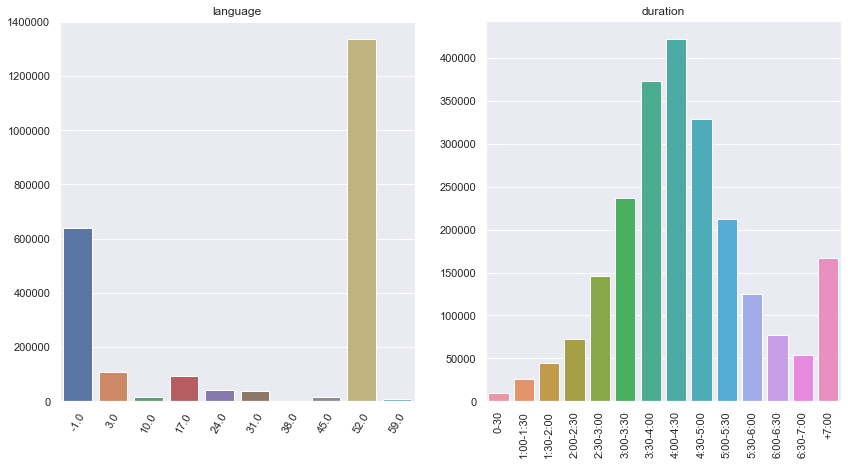

In [41]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.clf()
plt.figure(figsize = (14, 7))
plt.subplot(121)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.countplot(songs.language)
plt.title('language')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.subplot(122)
bins = [0,30000,60000,90000,120000,150000,180000,210000,240000,270000, 300000, 330000, 360000, 390000, 100000000]
labels = ['0-30','1:00-1:30','1:30-2:00','2:00-2:30','2:30-3:00','3:00-3:30','3:30-4:00','4:00-4:30', '4:30-5:00', '5:00-5:30', '5:30-6:00', '6:00-6:30', '6:30-7:00', '+7:00']
sns.countplot(pd.cut(songs.song_length,bins=bins, labels=labels, right=False))
plt.title('duration')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='90')

plt.show()

Como podemos ver, la gráfica de duración de las canciones se asemeja a la gráfica de una distribución normal con la media entre 4:00 y 4:30 minutos. Parece que los NA's vienen codificados como -1 en en Lenguaje

In [42]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


Estudio de **members.csv**:

<Figure size 432x288 with 0 Axes>

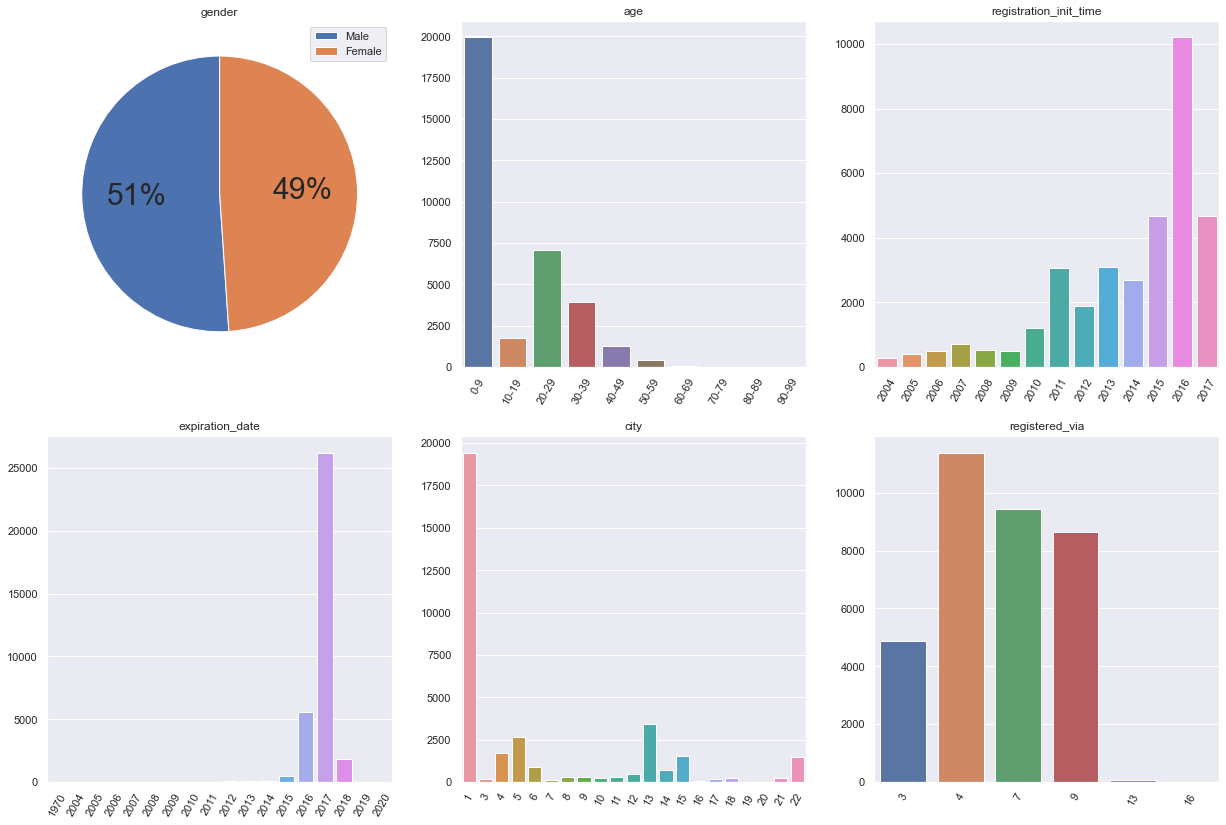

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.clf()
mpl.rcParams['font.size'] = 30.0
labels = ['Male','Female']
plt.figure(figsize = (21, 14))
plt.subplot(231)
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90, labeldistance = None)
plt.title('gender')                                    
plt.legend()

bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']
plt.subplot(232)
sns.countplot(pd.cut(members.bd, bins=bins, labels=labels, right=False))
plt.title('age')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.subplot(233)
sns.countplot(members.registration_init_time.astype(str).str[:4].astype(int))
plt.title('registration_init_time')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.subplot(234)
sns.countplot(members.expiration_date.astype(str).str[:4].astype(int))
plt.title('expiration_date')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.subplot(235)
sns.countplot(members.city.astype(int))
plt.title('city')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.subplot(236)
sns.countplot(members.registered_via)
plt.title('registered_via')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation='60')

plt.show()

Aquí tenemos una visualización en crudo de los datos de **members.csv**, en la que ya podemos intuír que hay NA's en la edad que vienen como 0's y en City que vienen como 1's. Además la ciudad y el método de registro de los usuarios está codificado y estos códigos no han sido publicados, igual que el lenguaje de las canciones, probablemente tenga que ver con la Ley de Protección de Datos. El número de registros va en aumento, y las fechas de expiración están todas muy próximas al 2017, año de publicación de estos datos.

In [44]:
members.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,34403.000000,34403.000000,34403.000000,3.440300e+04,3.440300e+04
mean,5.371276,12.280935,5.953376,2.013994e+07,2.016901e+07
std,6.243929,18.170251,2.287534,2.954015e+04,7.320925e+03
min,1.000000,-43.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012103e+07,2.017020e+07
50%,1.000000,0.000000,7.000000,2.015090e+07,2.017091e+07
75%,10.000000,25.000000,9.000000,2.016110e+07,2.017093e+07
max,22.000000,1051.000000,16.000000,2.017023e+07,2.020102e+07


<a name='6.2'></a>
### Elementos no incluídos

A continuación mostramos una parte eliminada de nuestra ingeniería de variables, al final comentaremos el error:

Debemos tener en cuenta que estamos trabajando con un dataset con varias tablas, y cuyo objetivo es detectar eventos de escucha potencialmente repetitivos en un período de tiempo en una aplicación musical. Aquí el inciso, el caso más habitual es que un usuario que ya existe en la aplicación con su experiencia en más escuchas pulsa el play de una canción que ya ha sido escuchada por más usuarios. Por tanto, y como estamos hablando de una información en constante dinamismo, tanto para la canción que recibe constantes escuchas, como para el usuario que consume música constantemente, es útil y debemos relacionar la información que tenemos en la variable objetivo con las canciones y los usuarios y almacenarla en nuestro conjunto de entrenamiento.

Es importante percatarse de que esta información no nos ayudará con un usuario nuevo, ni con una canción que acaba de salir, pero dado el contexto del problema podemos interpretar que ese no es el objetivo principal de nuestro problema (el grueso en la plataforma está en canciones que ya han sido escuchadas alguna vez y usuarios que ya son miembros) y que nuestras variables creadas a partir de la variable objetivo están bien definidas y agregarán información de interés al problema para detectar la repetición en futuros eventos de escucha.

Lo que haremos será crear y agegar al conjunto de entrenamiento variables con el número y porcentaje de repeticiones de escucha que ha provocado cada canción, artista, o usuario, y tendremos en cuenta solo las que estén representadas por al menos 3 muestras.

In [45]:
song_count = df_train.loc[:,["song_id","target"]]
song_count1 = song_count.groupby(["song_id"],as_index=False).sum().rename(columns={"target" : "repeat_count_song"}).astype({'repeat_count_song' : 'int'})
song_count2 = song_count.groupby(["song_id"],as_index=False).count().rename(columns = {"target" : "play_count_song"})

song_repeat = song_count1.merge(song_count2,how="inner",on="song_id")
song_repeat['repeat_percentage_song'] = round((song_repeat['repeat_count_song']*100) / song_repeat['play_count_song'],1)
song_repeat.loc[song_repeat['play_count_song'] < 3, 'repeat_percentage_song'] = 0
song_repeat = song_repeat.drop("play_count_song", axis = 1)

df_train = df_train.merge(song_repeat,on="song_id",how="left")
df_test = df_test.merge(song_repeat,on="song_id",how="left")

In [46]:
artist_count = df_train.loc[:,["artist_name","target"]]
artist_count1 = artist_count.groupby(["artist_name"],as_index=False).sum().rename(columns={"target" : "repeat_count_artist"}).astype({'repeat_count_artist' : 'int'})
artist_count2 = artist_count.groupby(["artist_name"],as_index=False).count().rename(columns = {"target" : "play_count_artist"})

artist_repeat = artist_count1.merge(artist_count2,how="inner",on="artist_name")

artist_repeat['repeat_percentage_artist'] = round((artist_repeat['repeat_count_artist']*100) / artist_repeat['play_count_artist'],1)
artist_repeat['repeat_count_artist'] = artist_repeat['repeat_count_artist'].fillna(0)
artist_repeat.loc[artist_repeat['play_count_artist'] < 3, 'repeat_percentage_artist'] = 0
artist_repeat = artist_repeat.drop("play_count_artist", axis = 1)

df_train = df_train.merge(artist_repeat,on="artist_name",how="left")
df_test = df_test.merge(artist_repeat,on="artist_name",how="left")

In [47]:
msno_count = train.loc[:,['msno','target']]
msno_count1 = msno_count.groupby(['msno'],as_index=False).sum().rename(columns={'target':'repeat_count_msno'}).astype({'repeat_count_msno':'int'})
msno_count2 = msno_count.groupby(['msno'],as_index=False).count().rename(columns = {'target':'play_count_msno'})

msno_repeat = msno_count1.merge(msno_count2,how='inner',on='msno')

msno_repeat['repeat_percentage_msno'] = round((msno_repeat['repeat_count_msno']*100) / msno_repeat['play_count_msno'],1)
msno_repeat['repeat_count_msno'] = msno_repeat['repeat_count_msno'].fillna(0)
msno_repeat.loc[msno_repeat['play_count_msno'] < 3, 'repeat_percentage_msno'] = 0
msno_repeat = msno_repeat.drop("play_count_msno", axis = 1)

df_train = df_train.merge(msno_repeat,on='msno',how='left')
df_test = df_test.merge(msno_repeat,on='msno',how='left')

El error de hacer esto es que la suposición de que no estamos sobreajustando porque el grueso del conjunto de datos está en canciones ya escuchadas y usuarios ya registrados es válida si estuviésemos tratando con el conjunto total de datos de canciones y usuarios de la aplicación, entonces estaríamos trabajando con los mismos usuarios y canciones que en el conjunto de entrenamiento. Probablemente se trata de una muestra, y no haya tantas coincidencias como esperamos, por lo tanto este fragmento de código sobreajustaba el modelo, lógicamente estas variables recibían una gran importancia y el modelo no servía una vez entrenado con otros conjuntos de datos.

<a name='6.3'></a>
### Código

<Figure size 432x288 with 0 Axes>

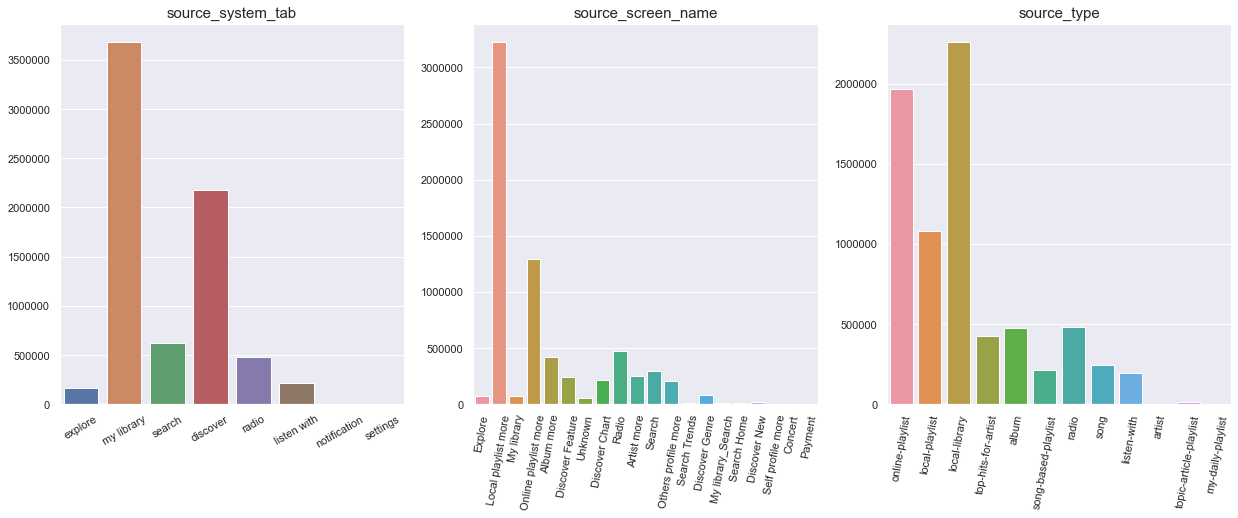

2621293 308752 2940499 935979 116856 1043221
0 0 0 0 0 0
False False
Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables numéricas :   766.8862934112549 / 273.0946350097656 MB
Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables categóricas :   384.5170097351074 / 139.16364097595215 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 22 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              int8    
 6   city                category
 7   bd                  int8    
 8   gender              category
 9   registered_via      category
 10  song_length         int32   
 11  genre_ids           category
 12  artist_nam

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.678858
[2]	valid_0's auc: 0.687804
[3]	valid_0's auc: 0.688057
[4]	valid_0's auc: 0.687912
[5]	valid_0's auc: 0.688177
[6]	valid_0's auc: 0.688052
[7]	valid_0's auc: 0.688656
[8]	valid_0's auc: 0.690064
[9]	valid_0's auc: 0.690732
[10]	valid_0's auc: 0.690637
[11]	valid_0's auc: 0.691255
[12]	valid_0's auc: 0.691357
[13]	valid_0's auc: 0.691823
[14]	valid_0's auc: 0.691867
[15]	valid_0's auc: 0.691981
[16]	valid_0's auc: 0.69373
[17]	valid_0's auc: 0.693714
[18]	valid_0's auc: 0.693788
[19]	valid_0's auc: 0.69402
[20]	valid_0's auc: 0.694937
[21]	valid_0's auc: 0.695025
[22]	valid_0's auc: 0.695191
[23]	valid_0's auc: 0.695193
[24]	valid_0's auc: 0.695291
[25]	valid_0's auc: 0.695262
[26]	valid_0's auc: 0.695492
[27]	valid_0's auc: 0.695524
[28]	valid_0's auc: 0.695588
[29]	valid_0's auc: 0.696182
[30]	valid_0's auc: 0.696158
[31]	valid_0's auc: 0.696331
[32]	valid_0's auc: 0.696329
[33]	valid_0's auc: 0.696259
[34]	valid_0's auc: 0.696281
[35]	valid_0's auc: 0.696

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.67268
[2]	valid_0's auc: 0.688032
[3]	valid_0's auc: 0.689156
[4]	valid_0's auc: 0.690175
[5]	valid_0's auc: 0.688606
[6]	valid_0's auc: 0.689464
[7]	valid_0's auc: 0.689703
[8]	valid_0's auc: 0.690454
[9]	valid_0's auc: 0.690895
[10]	valid_0's auc: 0.691384
[11]	valid_0's auc: 0.691557
[12]	valid_0's auc: 0.691921
[13]	valid_0's auc: 0.692026
[14]	valid_0's auc: 0.69191
[15]	valid_0's auc: 0.692454
[16]	valid_0's auc: 0.693494
[17]	valid_0's auc: 0.693554
[18]	valid_0's auc: 0.693721
[19]	valid_0's auc: 0.693737
[20]	valid_0's auc: 0.694949
[21]	valid_0's auc: 0.695079
[22]	valid_0's auc: 0.695133
[23]	valid_0's auc: 0.69555
[24]	valid_0's auc: 0.695606
[25]	valid_0's auc: 0.695675
[26]	valid_0's auc: 0.696228
[27]	valid_0's auc: 0.696249
[28]	valid_0's auc: 0.696245
[29]	valid_0's auc: 0.696822
[30]	valid_0's auc: 0.696787
[31]	valid_0's auc: 0.696831
[32]	valid_0's auc: 0.696799
[33]	valid_0's auc: 0.696931
[34]	valid_0's auc: 0.6969
[35]	valid_0's auc: 0.696885

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.661107
[2]	valid_0's auc: 0.671634
[3]	valid_0's auc: 0.672079
[4]	valid_0's auc: 0.672097
[5]	valid_0's auc: 0.673057
[6]	valid_0's auc: 0.674082
[7]	valid_0's auc: 0.674598
[8]	valid_0's auc: 0.674612
[9]	valid_0's auc: 0.675077
[10]	valid_0's auc: 0.676144
[11]	valid_0's auc: 0.676479
[12]	valid_0's auc: 0.677168
[13]	valid_0's auc: 0.677463
[14]	valid_0's auc: 0.67796
[15]	valid_0's auc: 0.678608
[16]	valid_0's auc: 0.679765
[17]	valid_0's auc: 0.679714
[18]	valid_0's auc: 0.679511
[19]	valid_0's auc: 0.679947
[20]	valid_0's auc: 0.680628
[21]	valid_0's auc: 0.680667
[22]	valid_0's auc: 0.680773
[23]	valid_0's auc: 0.680797
[24]	valid_0's auc: 0.681249
[25]	valid_0's auc: 0.681194
[26]	valid_0's auc: 0.681392
[27]	valid_0's auc: 0.681478
[28]	valid_0's auc: 0.681446
[29]	valid_0's auc: 0.681791
[30]	valid_0's auc: 0.681826
[31]	valid_0's auc: 0.682009
[32]	valid_0's auc: 0.681949
[33]	valid_0's auc: 0.682055
[34]	valid_0's auc: 0.682072
[35]	valid_0's auc: 0.68

2556790

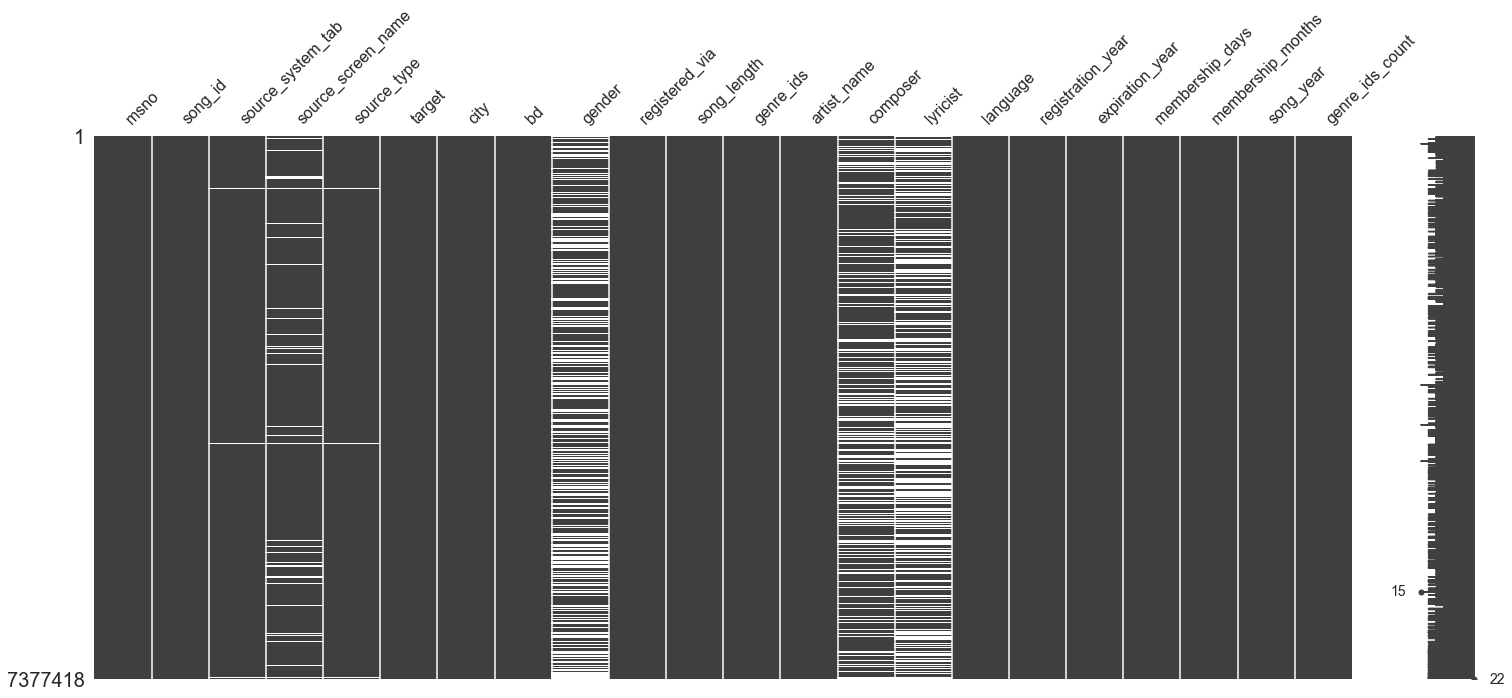

In [48]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import gc
import seaborn as sns 
import missingno as msno
import warnings
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve

train = pd.read_csv('./kkbox_data/train.csv')
test = pd.read_csv('./kkbox_data/test.csv')
songs = pd.read_csv('./kkbox_data/songs.csv')
members = pd.read_csv('./kkbox_data/members.csv')

plt.clf()
plt.figure(figsize=(21, 7))
plt.subplot(131)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_system_tab',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_system_tab',fontsize=15)
plt.xticks(rotation='30')

plt.subplot(132)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_screen_name',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_screen_name',fontsize=15)
plt.xticks(rotation='80')

plt.subplot(133)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.set(font_scale=1)
sns.countplot(x='source_type',data=train)
plt.xlabel('')
plt.ylabel('')
plt.title('source_type',fontsize=15)
plt.xticks(rotation='80')

plt.show()


train_members = pd.merge(train, members, on='msno', how='inner')
df_train = pd.merge(train_members, songs, on='song_id', how='left')
df_train.head(1)

test_members = pd.merge(test, members, on='msno', how='inner')
df_test = pd.merge(test_members, songs, on='song_id', how='left')
df_test.head(1)

del train_members
del test_members

print(sum(df_train.city == 1),sum(df_train.language == -1),sum(df_train.bd == 0),sum(df_test.city == 1),sum(df_test.language == -1),sum(df_test.bd == 0))
df_train.loc[df_train['city']==1,'city'] = -5
df_train.loc[df_train['language']==-1,'language'] = -5
df_train.loc[df_train['bd']==0,'bd'] = -5
df_test.loc[df_test['city']==1,'city'] = -5
df_test.loc[df_test['language']==-1,'language'] = -5
df_test.loc[df_test['bd']==0,'bd'] = -5
print(sum(df_train.city == 1),sum(df_train.language == -1),sum(df_train.bd == 0),sum(df_test.city == 1),sum(df_test.language == -1),sum(df_test.bd == 0))


df_train.registration_init_time = pd.to_datetime(df_train.registration_init_time, format='%Y%m%d', errors='ignore')
df_train['registration_year'] = df_train['registration_init_time'].dt.year
#df_train['registration_month'] = df_train['registration_init_time'].dt.month
#df_train['registration_day'] = df_train['registration_init_time'].dt.day

df_test.registration_init_time = pd.to_datetime(df_test.registration_init_time, format='%Y%m%d', errors='ignore')
df_test['registration_year'] = df_test['registration_init_time'].dt.year
#df_test['registration_month'] = df_test['registration_init_time'].dt.month
#df_test['registration_day'] = df_test['registration_init_time'].dt.day

df_train.expiration_date = pd.to_datetime(df_train.expiration_date,  format='%Y%m%d', errors='ignore')
df_train['expiration_year'] = df_train['expiration_date'].dt.year
#df_train['expiration_month'] = df_train['expiration_date'].dt.month
#df_train['expiration_day'] = df_train['expiration_date'].dt.day

df_test.expiration_date = pd.to_datetime(df_test.expiration_date,  format='%Y%m%d', errors='ignore')
df_test['expiration_year'] = df_test['expiration_date'].dt.year
#df_test['expiration_month'] = df_test['expiration_date'].dt.month
#df_test['expiration_day'] = df_test['expiration_date'].dt.day

df_train['membership_days'] = (df_train['expiration_date'] - df_train['registration_init_time']).dt.days.astype(int)
df_test['membership_days'] = (df_test['expiration_date'] - df_test['registration_init_time']).dt.days.astype(int)
df_train['membership_months'] = df_train['membership_days']//30.42
df_test['membership_months'] = df_test['membership_days']//30.42

df_train = df_train.drop('registration_init_time', axis=1)
df_test = df_test.drop('registration_init_time', axis=1)
df_train = df_train.drop('expiration_date', axis=1)
df_test = df_test.drop('expiration_date', axis=1)

song_extra_info = pd.read_csv('./kkbox_data/song_extra_info.csv')

def isrc_to_year(isrc):
    if not pd.isnull(isrc) and type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return -5

song_extra_info['song_year'] = song_extra_info['isrc'].apply(isrc_to_year).apply(int)
song_extra_info.drop(['isrc', 'name'], axis = 1, inplace = True)

df_train = df_train.merge(song_extra_info, on = 'song_id', how = 'left')
df_test = df_test.merge(song_extra_info, on = 'song_id', how = 'left')

def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
df_train['genre_ids'].fillna('no_genre_id' , inplace= True)
df_train['genre_ids_count'] = df_train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
df_test['genre_ids'].fillna('no_genre_id' , inplace= True)
df_test['genre_ids_count'] = df_test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

df_train['genre_ids'] = df_train['genre_ids'].str.split('|').str[0]
df_test['genre_ids'] = df_test['genre_ids'].str.split('|').str[0]

msno.matrix(df_train)

def replace_NA_non_object(df):
    object_cols = list(df.select_dtypes(include=['float64','int64']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(int(-5))

def replace_NA_object(df):
    for i in df.select_dtypes(include=['object']).columns:
        df.loc[df[i].isnull(),i] = 'unknown'

df_train['song_length'].fillna(df_train['song_length'].mean() , inplace = True)
df_train['language'].fillna(df_train['language'].mode().values[0] , inplace= True)
df_test['song_length'].fillna(df_test['song_length'].mean() , inplace = True)
df_test['language'].fillna(df_test['language'].mode().values[0] , inplace= True)

df_train.loc[df_train['composer'].isnull(),'composer'] = df_train.loc[df_train['composer'].isnull(),'artist_name']
df_train.loc[df_train['lyricist'].isnull(),'lyricist'] = df_train.loc[df_train['lyricist'].isnull(),'artist_name']
replace_NA_non_object(df_train)
replace_NA_non_object(df_test)
replace_NA_object(df_train)
replace_NA_object(df_test)
 
print(df_train.isnull().values.any(),df_test.isnull().values.any()) # comprobacion de que no quedan NA

def asign_numeric_datatypes(df):
    float_cols = list(df.select_dtypes(include=['int','float']).columns) 
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

asign_numeric_datatypes(df_train)
asign_numeric_datatypes(df_test)

print("Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables numéricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

df_train = df_train.astype({
                    'msno' : 'category',
                    'song_id' : 'category',
                    'source_system_tab' : 'category',
                    'source_screen_name' : 'category',
                    'source_type' : 'category',
                    'target' : 'int8',
                    'city' : 'category',
                    'bd' : 'int8',
                    'gender' : 'category',
                    'registered_via' : 'category',
                    'genre_ids' : 'category',
                    'artist_name' : 'category',
                    'composer' : 'category',
                    'lyricist' : 'category',
                    'language' : 'category'                    
                })

df_test = df_test.astype({
                    'msno' : 'category',
                    'song_id' : 'category',
                    'source_system_tab' : 'category',
                    'source_screen_name' : 'category',
                    'source_type' : 'category',
                    'city' : 'category',
                    'bd' : 'int8',
                    'gender' : 'category',
                    'registered_via' : 'category',
                    'genre_ids' : 'category',
                    'artist_name' : 'category',
                    'composer' : 'category',
                    'lyricist' : 'category',
                    'language' : 'category'                    
                })

print("Memoria consumida por el conjunto de training/test después de los cambios de tipo de dato de las variables categóricas :   {} / {} MB" .format(df_train.memory_usage(index=True).sum()/ 1024**2,df_test.memory_usage(index=True).sum()/ 1024**2))

df_train.info()

from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

predictions = np.zeros(shape=[len(df_test)])

for train_indices ,validate_indices in kf.split(df_train) : 
    train_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[train_indices,:],label=df_train.loc[train_indices,'target'])
    val_data = lgb.Dataset(df_train.drop(['target'],axis=1).loc[validate_indices,:],label=df_train.loc[validate_indices,'target'])

    params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 2**8,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 80,
        'metric' : 'auc'
    }
    lgbm_model = lgb.train(params, train_data, 100, valid_sets=[val_data])
    predictions += lgbm_model.predict(df_test.drop(['id'],axis=1))
    del lgbm_model

predictions = predictions/3

ids = df_test['id'].values
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = predictions
sub.to_csv('submission.csv' , index = False , float_format ='%.5f')
len(sub)